### Imports

In [1]:
import numpy as np
import pandas as pd

from scipy.integrate import odeint
from scipy.optimize import differential_evolution, fmin_tnc

import sdeparams

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='Set2')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

import warnings
warnings.filterwarnings('ignore')

### Function definitions

In [19]:
ndim = 5

def A(x, *params):
    Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, N = params
    b0, ba, a0, m, r = np.maximum(x, np.zeros(ndim))
    return np.array([Cbr*(b0 + ba)*r + ib*r - Cab*(ba + a0)*b0 - ia*b0 - (Cm*m + im)*b0 - mb*b0 + ma*ba,
                     Cab*(ba + a0)*b0 + ia*b0 - (Cm*m + im)*ba - ma*ba - mb*ba,
                     Car*(ba + a0)*r + ia*r - (Cm*m + im)*a0 - ma*a0 + mb*ba,
                     (Cm*m + im)*(b0 + a0 + ba) - mm*m,
                     -Cbr*(b0 + ba)*r - ib*r - Car*(ba + a0)*r - ia*r + mb*b0 + ma*a0 + mm*m])

def B(x, *params):
    Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, N = params
    b0, ba, a0, m, r = np.maximum(x, np.zeros(ndim))
    return np.array([[Cbr*(b0 + ba)*r + ib*r + Cab*(ba + a0)*b0 + ia*b0 + (Cm*m + im)*b0 + mb*b0 + ma*ba,
                                 -Cab*(ba + a0)*b0 - ia*b0 - ma*ba, 0, -(Cm*m + im)*b0, -Cbr*(b0 + ba)*r - ib*r - mb*b0],
                                [-Cab*(ba + a0)*b0 - ia*b0 - ma*ba, Cab*(ba + a0)*b0 + ia*b0 + (Cm*m + im)*ba + ma*ba + mb*ba,
                                 -mb*ba, -(Cm*m + im)*ba, 0],
                                [0, -mb*ba, Car*(ba + a0)*r + ia*r + (Cm*m + im)*a0 + ma*a0 + mb*ba, -(Cm*m + im)*a0,
                                 -Car*(ba + a0)*r - ia*r - ma*a0],
                                [-(Cm*m + im)*b0, -(Cm*m + im)*ba, -(Cm*m + im)*a0, (Cm*m + im)*(b0 + a0 + ba) + mm*m, -mm*m],
                                [-Cbr*(b0 + ba)*r - ib*r - mb*b0, 0, -Car*(ba + a0)*r - ia*r - ma*a0, -mm*m,
                                 Cbr*(b0 + ba)*r + ib*r + Car*(b0 + a0)*r + ia*r + mb*b0 + ma*a0 + mm*m]
                               ])

def Jac(x, *params):
    Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, N = params
    y = np.maximum(x[:ndim], np.zeros(ndim))
    b0, ba, a0, m, r = y
    return np.array([[Cbr*r - Cab*(ba + a0) - ia - (Cm*m + im) - mb, Cbr*r - Cab*b0 + ma, - Cab*b0, - Cm*b0,
                  Cbr*(b0 + ba) + ib], [Cab*(ba + a0) + ia, Cab*b0 - (Cm*m + im) - ma - mb, Cab*b0, - Cm*ba, 0.],
                 [0., Car*r + mb, Car*r - (Cm*m + im) - ma, - Cm*a0, Car*(ba + a0) + ia],
                 [(Cm*m + im), (Cm*m + im), (Cm*m + im), Cm*(b0 + a0 + ba) - mm, 0.],
                 [-Cbr*r + mb, -Cbr*r - Car*r, -Car*r + ma, mm, -Cbr*(b0 + ba) - ib - Car*(ba + a0) - ia]])

In [3]:
def path(x, t, *params):
    dt = t[1]-t[0]
    
    N = params[-1]
    
    x_t = []
    
    x_0 = x.copy()
    for time in t:
        x_t.append(x_0.copy())
        y = A(x_0, *params)*dt + np.sqrt(dt/N)*np.random.multivariate_normal(np.zeros(ndim), B(x_0, *params))
        x_0 += y
            
    return np.array(x_t)

In [4]:
#Cbr = 0.018
#Cab = 0.049
#Cm = 0.078
#Car = 0.021
#mb = 0.003
#ma = 0.013
#mm = 0.017
#ib = 0.0000001
#ia = 0.0000001
#im = 0.0000001
#N = 200

#params = (Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, N)

#x0 = [0.1, 0.1, 0.1, 0.1, 0.6]

In [5]:
#dt = 0.1

#t_full = np.arange(0., 365*20., dt)
#x_real = path(x0, t_full, *params)

In [6]:
#fig, ax = plt.subplots(1, figsize=(18,5))
#labels = [r'$b_0$', r'$b_a$', r'$a_0$', r'$m$', r'$r$']
#for i in range(5):
#    ax.plot(t_full/365., x_real[:,i], linewidth=0.75, label=labels[i])
#ax.set_xlabel(r'$t\, \mathrm{(years)}$', fontsize=20)
#ax.legend(fontsize=18)
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)

### Importing and cleaning the data

In [7]:
data = pd.read_csv('./interpolated_data.csv', parse_dates=[0], dayfirst=True)
data = data.rename(columns={"'Date'": 'date', "'Barnacles [%]'": 'B', "'Crustose algae [%]'": 'A', "'Mussels [%] '": 'M',
                            "'Bare rock [%]'": 'R'})

In [8]:
b0 = np.empty_like(data.B)
ba = np.empty_like(data.B)
a0 = np.empty_like(data.B)
m = np.empty_like(data.B)
r = np.empty_like(data.B)

for idx, row in data.iterrows():
    if np.maximum(row['B'], row['A']) + row['M'] + row['R'] > 100.:
        if row['A'] > row['B']:
            b0[idx] = 0.
            ba[idx] = row['B']
            a0[idx] = row['A'] - row['B']
        else:
            b0[idx] = row['B'] - row['A']
            ba[idx] = row['A']
            a0[idx] = 0.
        m[idx] = row['M']
        r[idx] = 100. - (b0[idx] + ba[idx] + a0[idx] + m[idx])
        if r[idx] < 0:
            m[idx] = m[idx] + r[idx]
            r[idx] = 0.
    elif row['B'] + row['A'] + row['M'] + row['R'] < 100.:
        b0[idx] = row['B']
        ba[idx] = 0.
        a0[idx] = row['A']
        m[idx] = row['M']
        r[idx] = 100. - (b0[idx] + ba[idx] + a0[idx] + m[idx])
        if r[idx] < 0:
            m[idx] = m[idx] + r[idx]
            r[idx] = 0.
    else:
        ba[idx] = (row['B'] + row['A'] + row['M'] + row['R']) - 100.
        b0[idx] = row['B'] - ba[idx]
        a0[idx] = row['A'] - ba[idx]
        m[idx] = row['M']
        r[idx] = 100. - (b0[idx] + ba[idx] + a0[idx] + m[idx])
        
data['b0'] = b0/100.
data['ba'] = ba/100.
data['a0'] = a0/100.
data['m'] = m/100.
data['r'] = r/100.

In [9]:
date_init = data.date[0]

data['days'] = data['date'] - date_init
data['days'] = data['days'].apply(lambda x: int(x.days))

In [10]:
data_clean = data.drop(['date', 'B', 'A', 'M', 'R'], axis=1)
data_clean.index = data_clean.days
data_clean = data_clean.drop(['days'], axis=1)

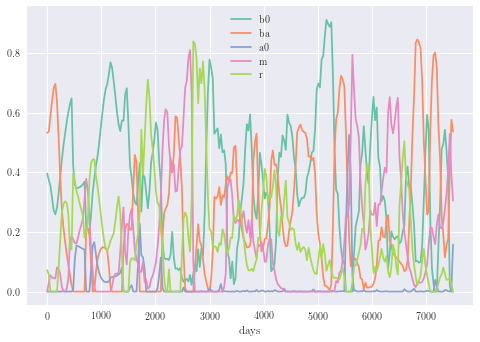

In [11]:
data_clean.plot()

In [12]:
ACFs = [np.correlate(data_clean[col],data_clean[col],mode='full')[np.argmax(np.correlate(data_clean[col],data_clean[col],mode='full')):]/np.max(np.correlate(data_clean[col],data_clean[col],mode='full'))
        for col in data_clean.columns]

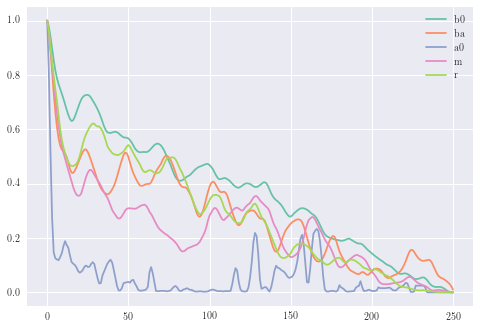

In [13]:
for i, acf in enumerate(ACFs):
    plt.plot(acf, label=data_clean.columns[i])
    plt.legend()

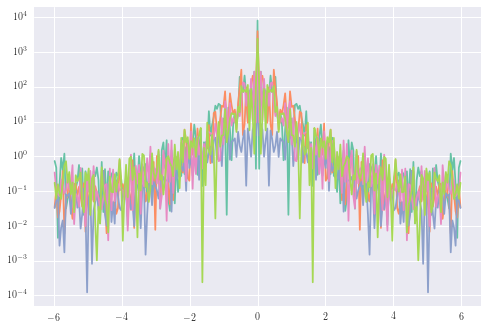

In [14]:
time_step = 1./12
for col in data_clean.columns:
    ps = np.abs(np.fft.fft(data_clean[col]))**2
    freqs = np.fft.fftfreq(data_clean[col].size, time_step)
    idx = np.argsort(freqs)

    plt.semilogy(freqs[idx], ps[idx])

### The estimation

In [20]:
observations = (data_clean.values, data_clean.index.values)

zimmer = sdeparams.Zimmer(A, B, Jac, observations, ndim)

In [21]:
bounds = [(0.001, 0.1), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1), (0.00001, 0.1), (0.00001, 0.1),
          (0.00001, 0.1), (0.00000001, 0.00001), (0., 0.), (0., 0.), (10, 200)]

estimation = differential_evolution(zimmer.costfn, bounds)

In [22]:
params_estim = tuple(estimation.x)

x_estim = zimmer.reconstruct(params_estim)

In [23]:
Cbr, Cab, Cm, Car, mb, ma, mm, ib, ia, im, N = params_estim

In [24]:
params_table = pd.DataFrame({r'$C_{br}$': Cbr, r'$C_{ab}$': Cab, r'$C_{m}$': Cm, r'$C_{ar}$': Car,
                             r'$m_{b}$': mb, r'$m_{a}$': ma, r'$m_{m}$': mm, r'$\alpha_{b}$': ib,
                             r'$\alpha_{a}$': ia, r'$\alpha_{m}$': im, r'$N$': N}, index=[0])

params_table

,$C_{ab}$,$C_{ar}$,$C_{br}$,$C_{m}$,$N$,$\alpha_{a}$,$\alpha_{b}$,$\alpha_{m}$,$m_{a}$,$m_{b}$,$m_{m}$
0,0.02813,0.001001,0.008378,0.011063,11.734756,0.0,6.222849e-07,0.0,0.00833,0.000362,0.003435


In [26]:
init_cond = np.concatenate((observations[0][0], np.zeros(ndim**2)))
t_full = np.linspace(observations[1][0], observations[1][-1], 1000)

x_det = odeint(zimmer.LNA, init_cond, t_full, args=params_estim)[:, :ndim]

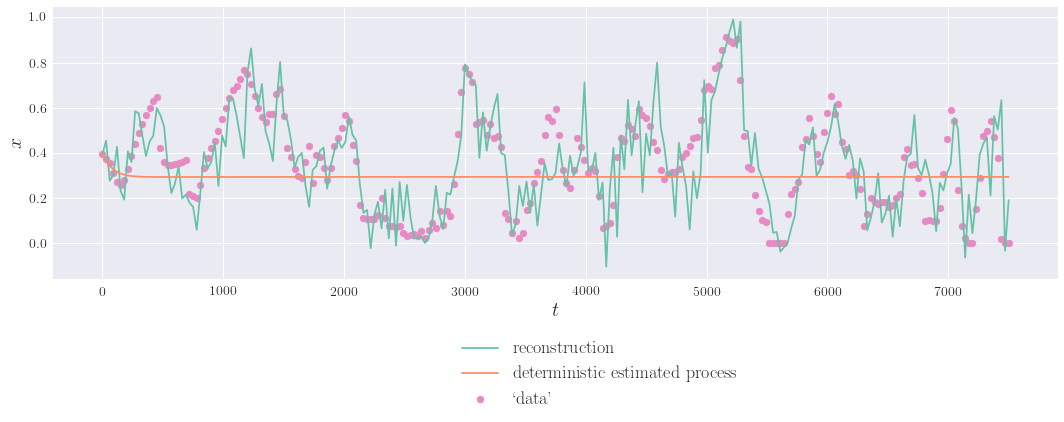

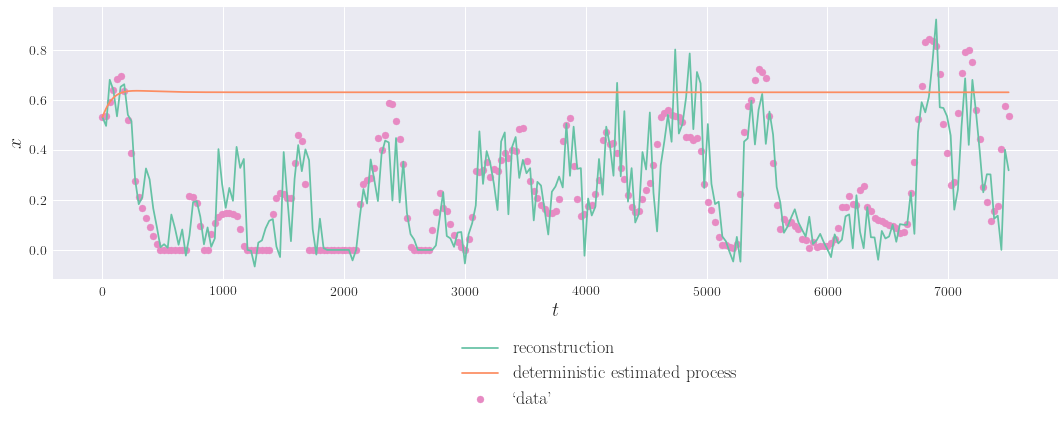

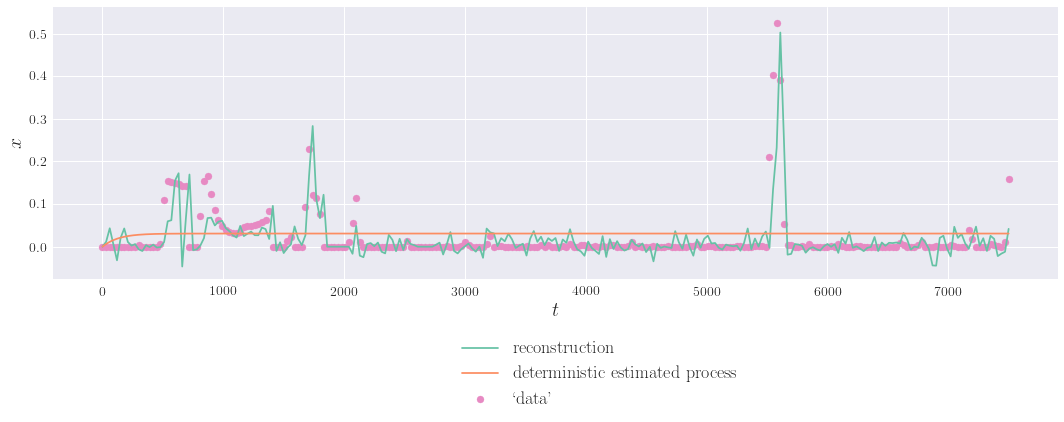

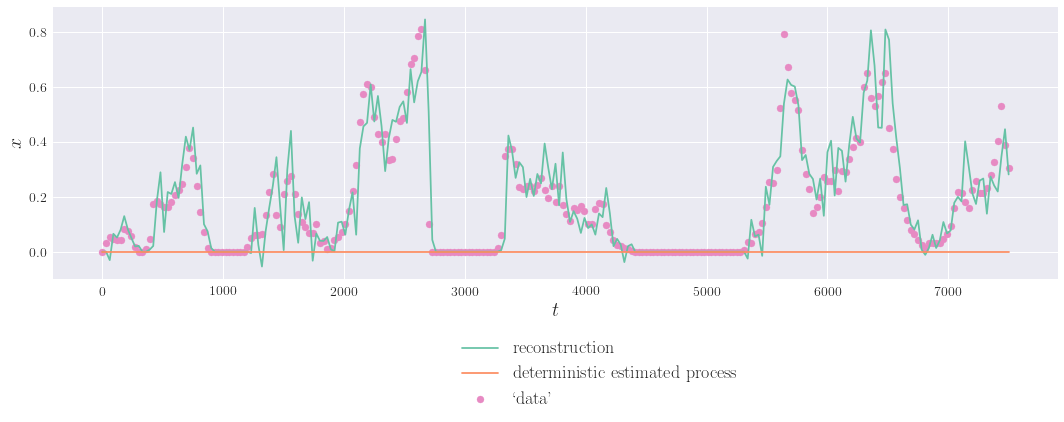

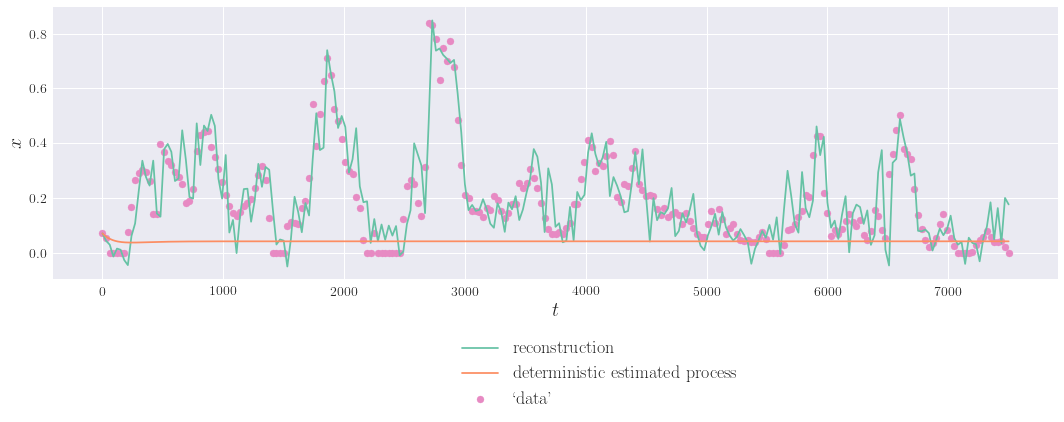

In [27]:
for i in range(ndim):
    fig, ax = plt.subplots(1, figsize=(18,5))
    ax.plot(observations[1], x_estim[:,i], label=r'reconstruction')
    ax.plot(t_full, x_det[:,i], label=r"deterministic estimated process")
    ax.scatter(observations[1], observations[0][:, i], color=colours[3], label=r"`data'")
    ax.set_xlabel(r'$t$', fontsize=20)
    ax.set_ylabel(r'$x$', fontsize=20)
    ax.legend(fontsize=18, loc=(0.4,-0.5))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [28]:
guess = [0.1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.00000001, 0., 0., 100]
bounds = [(0.001, 0.1), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1), (0.00001, 0.1), (0.00001, 0.1),
          (0.00001, 0.1), (0.00000001, 0.00001), (0., 0.), (0., 0.), (10, 200)]

estimation2 = fmin_tnc(zimmer.costfn, x0=guess, bounds=bounds, approx_grad=True)

In [29]:
params_estim2 = tuple(estimation2[0])

x_estim2 = zimmer.reconstruct(params_estim2)

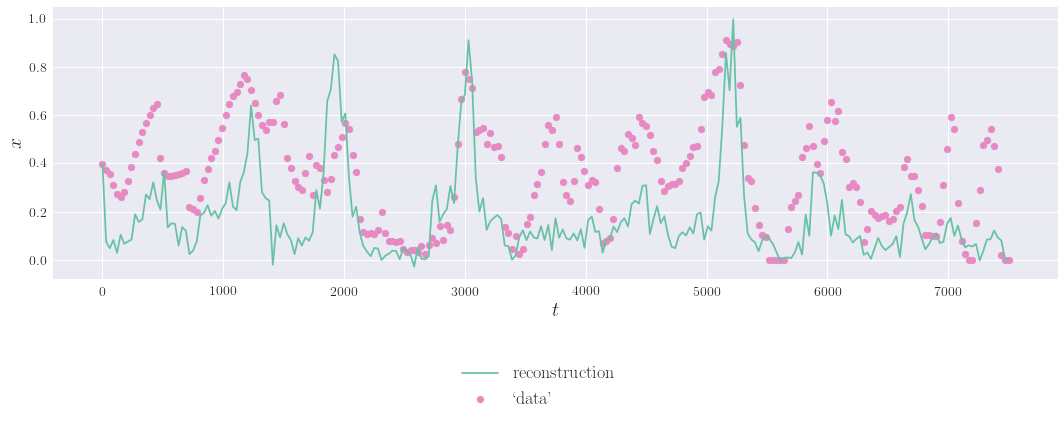

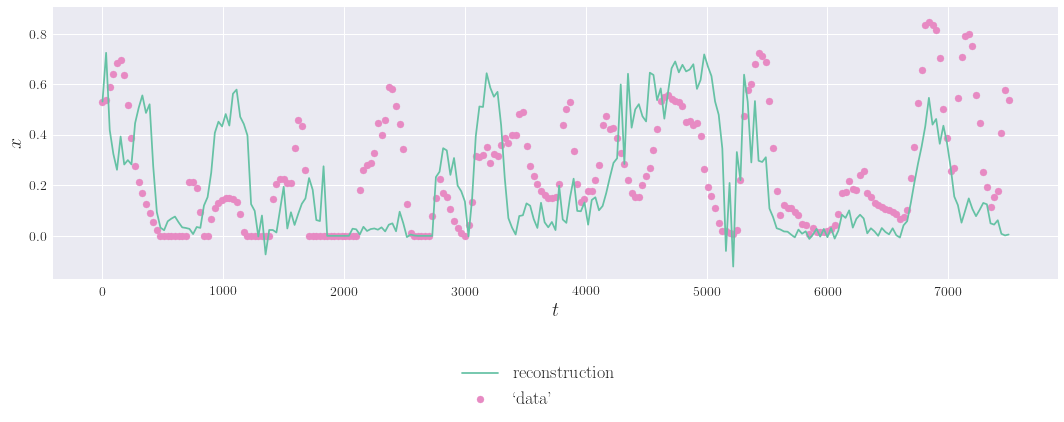

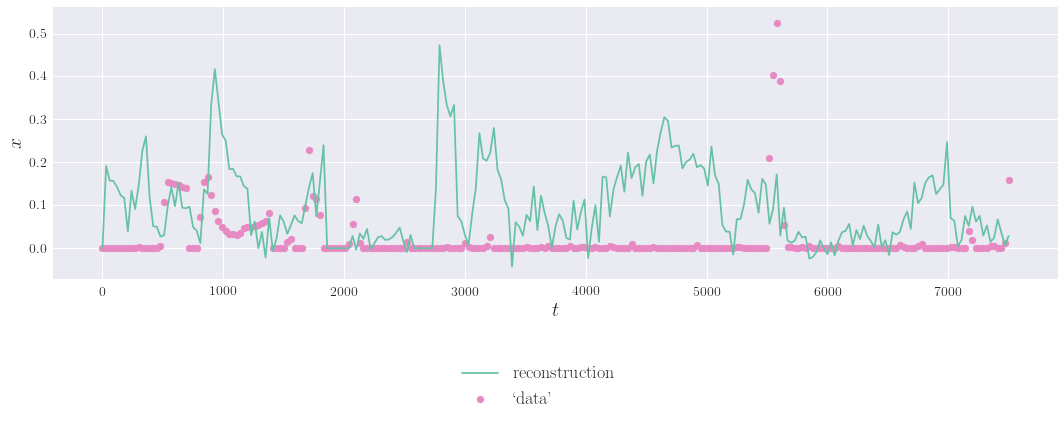

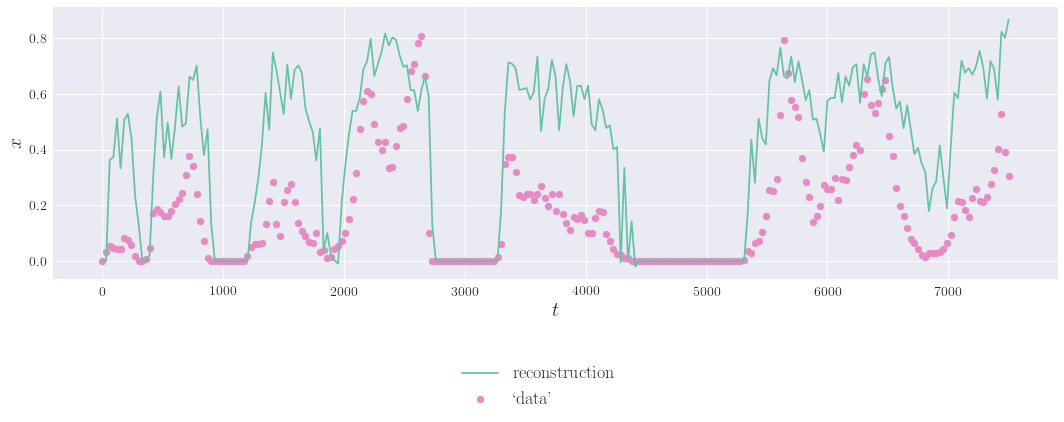

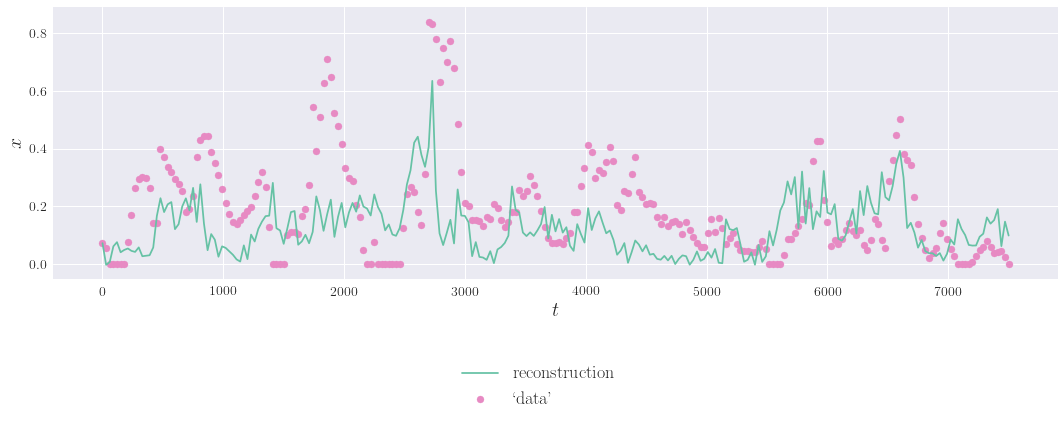

In [30]:
for i in range(ndim):
    fig, ax = plt.subplots(1, figsize=(18,5))
    ax.plot(observations[1], x_estim2[:,i], label=r'reconstruction')
#    ax.plot(t_full, x_det[:,i], label=r"deterministic estimated process")
    ax.scatter(observations[1], observations[0][:, i], color=colours[3], label=r"`data'")
    ax.set_xlabel(r'$t$', fontsize=20)
    ax.set_ylabel(r'$x$', fontsize=20)
    ax.legend(fontsize=18, loc=(0.4,-0.5))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [31]:
params_estim2

(0.1,
 0.1,
 0.1,
 0.1,
 0.010000000000000002,
 0.010000000000000002,
 0.010000000000000002,
 1e-08,
 0.0,
 0.0,
 100.0)